In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np


from spyglass.common import Session
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.decoding.v1.sorted_spikes import SortedSpikesDecodingV1

import os
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying")


from Analysis.utils import filter_opto_data, smooth
from ms_opto_stim_protocol import OptoStimProtocol
# from AnalysisTables import OptoStimTable
os.curdir



[2024-12-17 11:09:33,736][INFO]: Connecting sambray@lmf-db.cin.ucsf.edu:3306
[2024-12-17 11:09:33,875][INFO]: Connected sambray@lmf-db.cin.ucsf.edu:3306


'.'

# Populate

In [3]:
from AnalysisTables.decoding_tables import (
    ContinuousRippleTraversal,
    ContinuousRippleTraversalSelection,
    ContinuousRippleTraversalParams,
)
from spyglass.decoding.v1.clusterless import ClusterlessDecodingV1
from spyglass.ripple.v1 import RippleTimesV1
from spyglass.position.position_merge import PositionOutput

params = {
    "ripple_traversal_params_name": "default acausal",
    "continuous_distance_threshold": 3,
    "acausal": True,
}
ContinuousRippleTraversalParams().insert1(params, skip_duplicates=True)
ContinuousRippleTraversalParams()

ripple_traversal_params_name,continuous_distance_threshold,acausal
default acausal,3.0,1


In [4]:
from Analysis.utils import filter_opto_data

dataset_key = {"track_type": "early_wtrack"}
dataset = filter_opto_data(dataset_key)
dataset = dataset - "nwb_file_name LIKE 'banner%'"
pos_key = (PositionOutput.DLCPosV1()).proj(pos_merge_id="merge_id")
for key in dataset.fetch("KEY"):
    clusterless_query = ClusterlessDecodingV1() & {
        "nwb_file_name": key["nwb_file_name"],
        "position_group_name": "DLC " + key["interval_list_name"],
        "encoding_interval": key["interval_list_name"],
    }
    if not clusterless_query:
        continue
        # raise ValueError("No clusterless decoding found")
    clusterless_key = clusterless_query.fetch1("KEY")
    clusterless_key
    ripple_key = {
        "nwb_file_name": key["nwb_file_name"],
    }
    ripple_query = (
        RippleTimesV1
        & ripple_key
        & f"target_interval_list_name LIKE '%{key['interval_list_name']}%'"
        & pos_key
    )
    if not ripple_query:
        continue
        raise ValueError("No ripples found")
    ripple_key = ripple_query.fetch1("KEY")

    insert_key = {
        **ripple_key,
        **clusterless_key,
        "ripple_traversal_params_name": "default acausal",
    }
    ContinuousRippleTraversalSelection().insert1(insert_key, skip_duplicates=True)

    ContinuousRippleTraversalSelection()
ContinuousRippleTraversal().populate(processes=32)

datasets: 86


{'success_count': 0, 'error_list': []}

# Results


(0.0, 100.0)

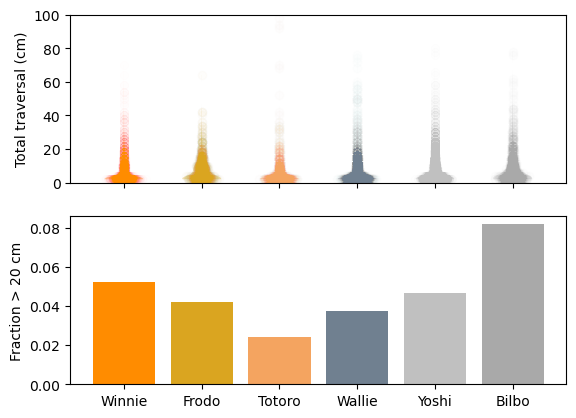

In [ ]:
from Style.style_guide import animal_style
from Analysis.utils import violin_scatter

i = 0
long_thresh = 20  # in cm

data = "longest"


fig, ax = plt.subplots(nrows=2, sharex=True)
animal_list = ["Winnie", "Frodo", "Totoro", "Wallie", "Yoshi", "Bilbo"]
for i, animal in enumerate(animal_list):
    query = ContinuousRippleTraversal() & f"nwb_file_name LIKE '{animal}%'"
    if not query:
        continue
    df = query.fetch_dataframe()
    if data == "total":
        val = df.total_traversal
    elif data == "longest":
        val = df.longest_traversal * 2  # (puts it in cm)
    else:
        raise ValueError("Data type not recognized")
    violin_scatter(val, color=animal_style.loc[animal, "color"], pos=i, ax=ax[0])

    fract = val > long_thresh

    ax[1].bar(i, fract.mean(), color=animal_style.loc[animal, "color"])

ax[0].set_ylabel("Total traversal (cm)")
ax[1].set_ylabel(f"Fraction > {long_thresh} cm")


ax[1].set_xticks(np.arange(i + 1))
ax[1].set_xticklabels(animal_list)
ax[0].set_ylim(0, 100)

# Plotting exemplar long traces


In [21]:
# Find good long continuous one
animal = "Totoro"
animal = "Winnie"
animal = "Yoshi"
animal = "Wallie"
query = ContinuousRippleTraversal() & f"nwb_file_name LIKE '{animal}%'"

longest_key = None
max_length = 0

for key in query.fetch("KEY"):
    df = (query & key).fetch1_dataframe()
    if df.longest_traversal.max() > max_length:
        max_length = df.longest_traversal.max()
        longest_key = key

query & longest_key
traversal_df = (query & longest_key).fetch1_dataframe()

In [22]:
Decoder = ClusterlessDecodingV1
# Decoder = SortedSpikesDecodingV1

nwb_file_name = longest_key["nwb_file_name"]
interval = longest_key["position_group_name"].strip("DLC ")
encoding_tag = ""  # "_opto_control_interval"
causal_tag = ""  # "_causal"
key = {
    "nwb_file_name": nwb_file_name,
    "position_group_name": "DLC " + interval,
    "encoding_interval": interval + encoding_tag,
}
key = (
    (Decoder() & key)
    & f"decoding_param_name LIKE '%{causal_tag}'"
    # & "sorted_spikes_group_name NOT LIKE 'manual%'"
).fetch1("KEY")

pos_df = Decoder().fetch_linear_position_info(key)
results = (Decoder() & key).fetch_results()
posterior = results.acausal_posterior.unstack("state_bins").sum("state")[0]
decode_pos = posterior.idxmax("position").values

opto_key = {
    "nwb_file_name": nwb_file_name,
    "interval_list_name": interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

if "sorted" in Decoder.full_table_name:
    spikes = Decoder().fetch_spike_data(key)
else:
    spikes = Decoder().fetch_spike_data(key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 5)
mua = mua / np.mean(np.diff(pos_df.index.values))
environment = Decoder().fetch_environments(key)[0]
distance_dict = environment.distance_between_nodes_

/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.8.0 because version 1.6.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/hdmf/spec/namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.5.0 because version 0.3.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
[2024-12-16 08:31:16,694][WARNING]: Skipped checksum for file with hash: 58ffbab6-d20f-178a-5c93-c07bb34a49ae, and path: /stelmo/nwb/analysis/Wallie20220922/Wallie20220922_8ed76e87-7b83-40f2-ae94-ec4be25b63b3.nc
[2024-12-16 08:31:34,337][WARNING]: Skipped checksum for file with hash: 404c68d5-3683-08d3-cc08-65781f5f8882, and path: /stelmo/nwb/raw/Wallie20220922_.nwb
/home/sambray/mambaforge-pypy

In [23]:
state_posterior = results.acausal_posterior.unstack("state_bins").sum("position")[0]
state_posterior.shape

(632745, 2)

In [31]:
ripple_num = np.argsort(traversal_df.longest_traversal.values)
ripple_num = ripple_num[-3]
print(traversal_df.iloc[ripple_num])
st = traversal_df.iloc[ripple_num].start_time
en = traversal_df.iloc[ripple_num].end_time
traversal_df.iloc[ripple_num]
longest_key

start_time           1.663897e+09
end_time             1.663897e+09
total_traversal      9.235336e+01
longest_traversal    2.900000e+01
Name: 17, dtype: float64


{'lfp_merge_id': UUID('27c0cbcf-691b-c069-e58c-f3e6e71fe0a2'),
 'filter_name': 'Ripple 150-250 Hz',
 'filter_sampling_rate': 1000,
 'nwb_file_name': 'Wallie20220922_.nwb',
 'target_interval_list_name': 'Wallie20220922_.nwb_pos 17 valid times_LFP_default_difference',
 'lfp_band_sampling_rate': 1000,
 'group_name': 'CA1',
 'ripple_param_name': 'default_ms',
 'pos_merge_id': UUID('8801dae8-23de-6096-11c1-f9ecca7f5d48'),
 'waveform_features_group_name': '18_wtrack',
 'position_group_name': 'DLC pos 17 valid times',
 'decoding_param_name': 'ms_wtrack_contfrag_clusterless_causal',
 'encoding_interval': 'pos 17 valid times',
 'decoding_interval': 'pos 17 valid times',
 'estimate_decoding_params': 0,
 'ripple_traversal_params_name': 'default acausal'}

[25885 25886 25887 25888 25889 25890 25891 25892 25893 25894 25895 25896
 25897 25898 25899 25900 25901 25902 25903 25904 25905 25906 25907 25908
 25909 25910 25911 25912 25913 25914 25915 25916 25917 25918 25919 25920
 25921 25922 25923 25924 25925 25926 25927 25928 25929 25930 25931 25932
 25933 25934 25935 25936 25937 25938 25939 25940 25941 25942 25943 25944
 25945 25946 25947 25948 25949 25950 25951 25952 25953 25954 25955 25956
 25957 25958 25959 25960 25961 25962 25963 25964 25965 25966 25967 25968
 25969 25970 25971 25972 25973 25974 25975 25976 25977 25978 25979 25980
 25981 25982 25983 25984 25985 25986 25987 25988 25989 25990 25991 25992
 25993 25994 25995 25996 25997 25998 25999 26000 26001 26002 26003 26004
 26005 26006 26007 26008 26009 26010 26011 26012 26013 26014 26015 26016
 26017 26018 26019 26020 26021 26022 26023 26024 26025 26026 26027 26028
 26029 26030 26031 26032 26033 26034 26035 26036 26037 26038 26039 26040
 26041 26042 26043 26044 26045 26046 26047 26048 26

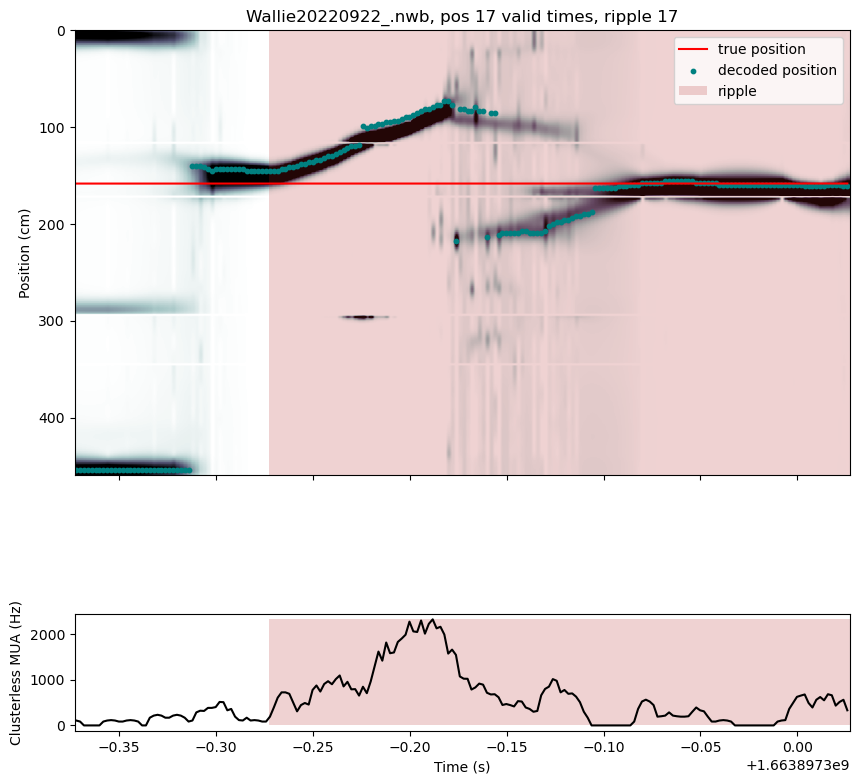

In [33]:
# pos_df
posterior.shape, pos_df.shape

# t0 = pos_df.index.values[0] - 9 * 60 + 30.4
t0 = 0

t_rng = (st - 0.1, st + 0.3)
# t_rng = (st - 0.1, st + 0.5)


fig, ax = plt.subplots(nrows=2, figsize=(10, 10), sharex=True, height_ratios=[20, 4])
# ax = [ax]
ind = np.where(
    (pos_df.index.values >= t0 + t_rng[0]) & (pos_df.index.values < t0 + t_rng[1])
)[0]

ind

print(ind)
ax[0].imshow(
    posterior[ind].T,
    aspect=0.0005,
    extent=[*t_rng, results.position.max() + results.position.min() + 0, 0],
    cmap="bone_r",
    clim=[0, 0.05],
    zorder=-1,
)
t_plot = pos_df.index[ind].values - t0
ax[0].plot(t_plot, linear_pos[ind], "r", label="true position")
ax[0].scatter(t_plot, decode_pos[ind], color="teal", s=10, label="decoded position")


ax[1].plot(t_plot, mua[ind], "k")


ax[0].fill_between(
    [st, en],
    0,
    np.nanmax(linear_pos),
    facecolor="firebrick",
    alpha=0.2,
    zorder=0,
    label="ripple",
)
ax[1].fill_between(
    [st, en], 0, np.nanmax(mua[ind]), facecolor="firebrick", alpha=0.2, zorder=0
)

ax[-1].set_xlabel("Time (s)")
ax[0].set_ylabel("Position (cm)")
ax[0].set_title(f"{nwb_file_name}, {interval}, ripple {ripple_num}")
ax[1].set_ylabel("Clusterless MUA (Hz)")
ax[0].legend()
plt.rcParams["svg.fonttype"] = "none"
fig.savefig(
    f"Figures_20241201/ripple_examples/{nwb_file_name}_{interval}_ripple_{ripple_num}.svg"
)

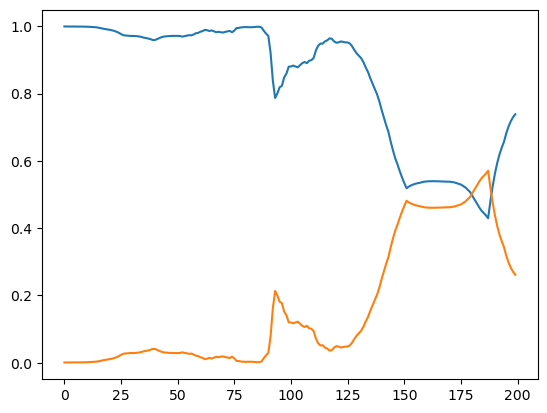

In [168]:
plt.plot(state_posterior[ind])

# Control Animal

In [36]:
ClusterlessDecodingV1 & {
    "nwb_file_name": "Winnie20220719_.nwb",
}

nwb_file_name name of the NWB file,waveform_features_group_name,position_group_name,decoding_param_name a name for this set of parameters,encoding_interval descriptive name of this interval list,decoding_interval descriptive name of this interval list,estimate_decoding_params whether to estimate the decoding parameters,results_path path to the results file,classifier_path path to the classifier file
Winnie20220719_.nwb,02_wtrack,DLC pos 1 valid times,ms_wtrack_contfrag_clusterless_causal,pos 1 valid times,pos 1 valid times,0,=BLOB=,=BLOB=
Winnie20220719_.nwb,02_wtrack,DLC pos 1 valid times,ms_wtrack_contfrag_clusterless_causal,pos 1 valid times_opto_control_interval,pos 1 valid times,0,=BLOB=,=BLOB=
Winnie20220719_.nwb,02_wtrack,DLC pos 1 valid times,ms_wtrack_contfrag_clusterless_causal,pos 1 valid times_opto_test_interval,pos 1 valid times,0,=BLOB=,=BLOB=
Winnie20220719_.nwb,02_wtrack,DLC pos 1 valid times,ms_wtrack_contfrag_clusterless_causal,pos 1 valid times_stimulus_on_interval,pos 1 valid times,0,=BLOB=,=BLOB=
Winnie20220719_.nwb,04_wtrack,DLC pos 3 valid times,ms_wtrack_contfrag_clusterless_causal,pos 3 valid times,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220719_.nwb,04_wtrack,DLC pos 3 valid times,ms_wtrack_contfrag_clusterless_causal,pos 3 valid times_opto_control_interval,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220719_.nwb,04_wtrack,DLC pos 3 valid times,ms_wtrack_contfrag_clusterless_causal,pos 3 valid times_opto_test_interval,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220719_.nwb,04_wtrack,DLC pos 3 valid times,ms_wtrack_contfrag_clusterless_causal,pos 3 valid times_stimulus_on_interval,pos 3 valid times,0,=BLOB=,=BLOB=
Winnie20220719_.nwb,06_wtrack,DLC pos 5 valid times,ms_wtrack_contfrag_clusterless_causal,pos 5 valid times,pos 5 valid times,0,=BLOB=,=BLOB=
Winnie20220719_.nwb,06_wtrack,DLC pos 5 valid times,ms_wtrack_contfrag_clusterless_causal,pos 5 valid times_opto_control_interval,pos 5 valid times,0,=BLOB=,=BLOB=


In [ ]:
Decoder = ClusterlessDecodingV1
# Decoder = SortedSpikesDecodingV1

interval = "pos 1 valid times"
encoding_tag = ""  # "_opto_control_interval"
causal_tag = ""  # "_causal"
key = {
    "nwb_file_name": "Yoshi20220518_.nwb",
    "position_group_name": "DLC " + interval,
    "encoding_interval": interval + encoding_tag,
}
key = (
    (Decoder() & key)
    & f"decoding_param_name LIKE '%{causal_tag}'"
    # & "sorted_spikes_group_name NOT LIKE 'manual%'"
).fetch1("KEY")

pos_df = Decoder().fetch_linear_position_info(key)
results = (Decoder() & key).fetch_results()
posterior = results.acausal_posterior.unstack("state_bins").sum("state")[0]
decode_pos = posterior.idxmax("position").values

opto_key = {
    "nwb_file_name": key["nwb_file_name"],
    "interval_list_name": interval,
}
stim, stim_time = OptoStimProtocol().get_stimulus(opto_key)

linear_pos = pos_df["linear_position"].values

if "sorted" in Decoder.full_table_name:
    spikes = Decoder().fetch_spike_data(key)
else:
    spikes = Decoder().fetch_spike_data(key)[0]
flat_spikes = np.concatenate(spikes)
spike_inds = np.digitize(flat_spikes, pos_df.index.values)
mua = np.bincount(spike_inds, minlength=len(pos_df))
mua = smooth(mua, 5)
environment = Decoder().fetch_environments(key)[0]
distance_dict = environment.distance_between_nodes_

KeyboardInterrupt: 

In [ ]:
# import os
# os.environ["JAX_PLATFORM_NAME"] = "cpu"
# classifier = (Decoder & key).fetch_model()
# classifier.encoding_model_
# for encoding_model in classifier.encoding_model_:
#     place_fields = np.asarray(
#         classifier.encoding_model_[encoding_model]["place_fields"]
#     )
#     norm_place = place_fields / np.mean(place_fields, axis=1)[:, None]
#     ind_plot = np.where(norm_place.max(axis=1) > 1.5)[0]
# # place_fields = np.asarray(
# #     classifier.encoding_model_[encoding_model]["place_fields"]
# # )
# neuron_sort_ind = np.argsort(np.nanargmax(place_fields, axis=1).squeeze())
# neuron_sort_ind = [x for x in neuron_sort_ind if x in ind_plot]

[254701 254702 254703 ... 258698 258699 258700]


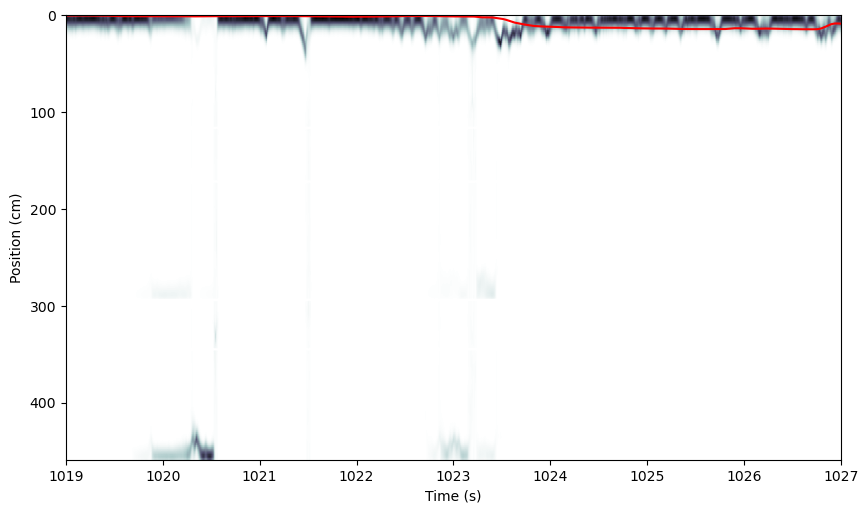

In [ ]:
# pos_df
posterior.shape, pos_df.shape

t0 = pos_df.index.values[0] - 9 * 60 + 30.4


st = 16 * 60 + 2 - 20
t_rng = (st, st + 50)

st = 17 * 60 + 2 - 3
t_rng = (st, st + 8)


# st=280.6
# t_rng=(st,281.7)
# st = 504 #- 19
# t_rng = (st, st+3)


# fig = plt.figure(figsize=(10,10))
fig, ax = plt.subplots(nrows=1, figsize=(10, 10), sharex=True)
ax = [ax]
ind = np.where(
    (pos_df.index.values >= t0 + t_rng[0]) & (pos_df.index.values < t0 + t_rng[1])
)[0]
print(ind)
ax[0].imshow(
    posterior[ind].T,
    aspect=0.01,
    extent=[*t_rng, np.nanmax(linear_pos), 0],
    cmap="bone_r",
)
ax[0].plot(pos_df.index[ind].values - t0, linear_pos[ind], "r")
# ax[0].plot(pos_df.index[ind].values - t0, decode_pos[ind], "teal")


stim_ind = np.where((stim_time >= t0 + t_rng[0]) & (stim_time < t0 + t_rng[1]))[0]
for i in range(len(stim_ind)):
    if i == 0 and stim[stim_ind[i]] == 0:
        ax[0].fill_betweenx(
            [0, linear_pos.max()],
            t0,
            stim_time[stim_ind[i]] - t0,
            color="thistle",
            alpha=0.5,
        )
    elif stim[stim_ind[i]] == 1:
        ax[0].fill_betweenx(
            [0, linear_pos.max()],
            stim_time[stim_ind[i]] - t0,
            stim_time[stim_ind[i + 1]] - t0,
            color="thistle",
            alpha=0.5,
        )


ax[-1].set_xlabel("Time (s)")
ax[0].set_ylabel("Position (cm)")
# ax[0].set_title(dataset_key)


j = 0
# for ii, s_ind in enumerate(neuron_sort_ind[::]):
#     spike_times = spikes[s_ind]

#     marks = (
#         spike_times[
#             np.logical_and(spike_times >= t0 + t_rng[0], spike_times < t0 + t_rng[1])
#         ]
#         - t0
#     )
#     if marks.size < 3 or marks.size > 50:
#         continue
#     ax[1].vlines(marks, j, j + 0.8, color="k")
#     j -= 1

# for i in range(len(stim_ind)):
#     if i == 0 and stim[stim_ind[i]] == 0:
#         ax[1].fill_betweenx(
#             [1, j + 1], t0, stim_time[stim_ind[i]] - t0, color="thistle", alpha=0.5
#         )
#     elif stim[stim_ind[i]] == 1:
#         ax[1].fill_betweenx(
#             [1, j + 1],
#             stim_time[stim_ind[i]] - t0,
#             stim_time[stim_ind[i + 1]] - t0,
#             color="thistle",
#             alpha=0.5,
#         )
# ax[1].set_ylabel("Unit")
# ax[1].set_ylim(j + 1, 1)

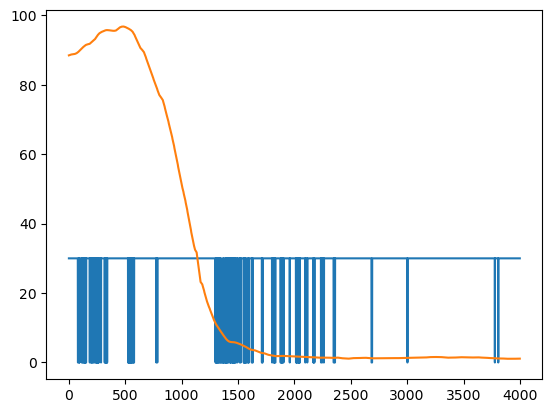

In [ ]:
ind = slice(6000, 10000)

plt.plot((np.abs(np.diff(decode_pos)) < 3).astype(int)[ind] * 30)


# plt.plot(np.abs(np.diff(decode_pos))[ind])
plt.plot(linear_pos[ind])

In [ ]:
from spyglass.ripple.v1 import RippleTimesV1
from spyglass.position.position_merge import PositionOutput

pos_table = PositionOutput.DLCPosV1().proj(pos_merge_id="merge_id")
ripple_query = (
    RippleTimesV1()
    & opto_key
    & f"target_interval_list_name LIKE '%{interval}%'"
    & pos_table
)
ripple_df = ripple_query.fetch1_dataframe()

In [ ]:
all_traversals = []
all_longest_traversals = []
for i, (st, en) in enumerate(zip(ripple_df.start_time, ripple_df.end_time)):
    # plt.axvspan(st, en, color="red", alpha=0.5)

    ind_st, ind_end = np.digitize([st, en], results.time)
    decode_pos_ripple = np.argmax(posterior[ind_st:ind_end].values, axis=1)
    distances = np.array(
        [
            distance_dict[x][y]
            for x, y in zip(decode_pos_ripple[:-1], decode_pos_ripple[1:])
        ]
    )
    continuous_decode = distances < 3
    total_valid_traversal = np.sum(continuous_decode * distances)
    total_valid_traversal
    all_traversals.append(total_valid_traversal)

    continuous_decode_switch = np.concatenate(
        [np.ones(1), np.diff(continuous_decode.astype(int))]
    )
    cont_st_list = np.where(continuous_decode_switch == 1)[0]
    cont_en_list = np.where(continuous_decode_switch == -1)[0]
    if len(cont_st_list) > len(cont_en_list):
        cont_en_list = np.concatenate([cont_en_list, [len(continuous_decode)]])
    continuous_valid_traversal = []
    for c_st, c_en in zip(cont_st_list, cont_en_list):
        # continuous_valid_traversal.append(np.sum(distances[c_st:c_en]*continuous_decode[c_st:c_en]))
        continuous_valid_traversal.append(np.unique(decode_pos_ripple[c_st:c_en]).size)
    longest_traversal = np.max(continuous_valid_traversal)
    all_longest_traversals.append(longest_traversal)
    # if total_valid_traversal >20:
    #     break
    # if longest_traversal >10:
    #     break

(array([129.,   0.,   0.,   0.,  87.,   0.,  22.,   0.,  28.,  17.,  14.,
         14.,  10.,   1.,   3.,   2.,   3.,   1.,   2.,   2.]),
 array([0.        , 0.07385606, 0.14771213, 0.22156819, 0.29542425,
        0.36928031, 0.44313638, 0.51699244, 0.5908485 , 0.66470456,
        0.73856063, 0.81241669, 0.88627275, 0.96012882, 1.03398488,
        1.10784094, 1.181697  , 1.25555307, 1.32940913, 1.40326519,
        1.47712125]),
 <BarContainer object of 20 artists>)

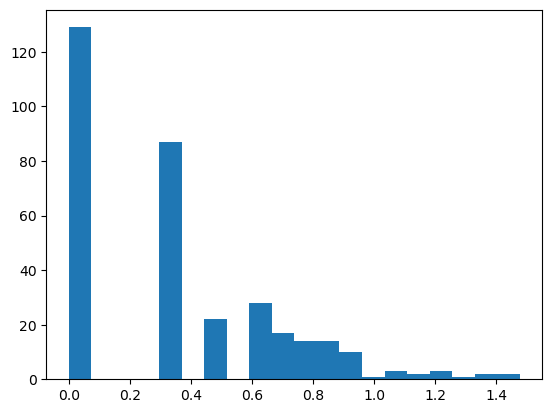

In [ ]:
# plt.hist(all_traversals,bins=20)
plt.hist(np.log10(all_longest_traversals), bins=20)

Text(0, 0.5, 'MUA')

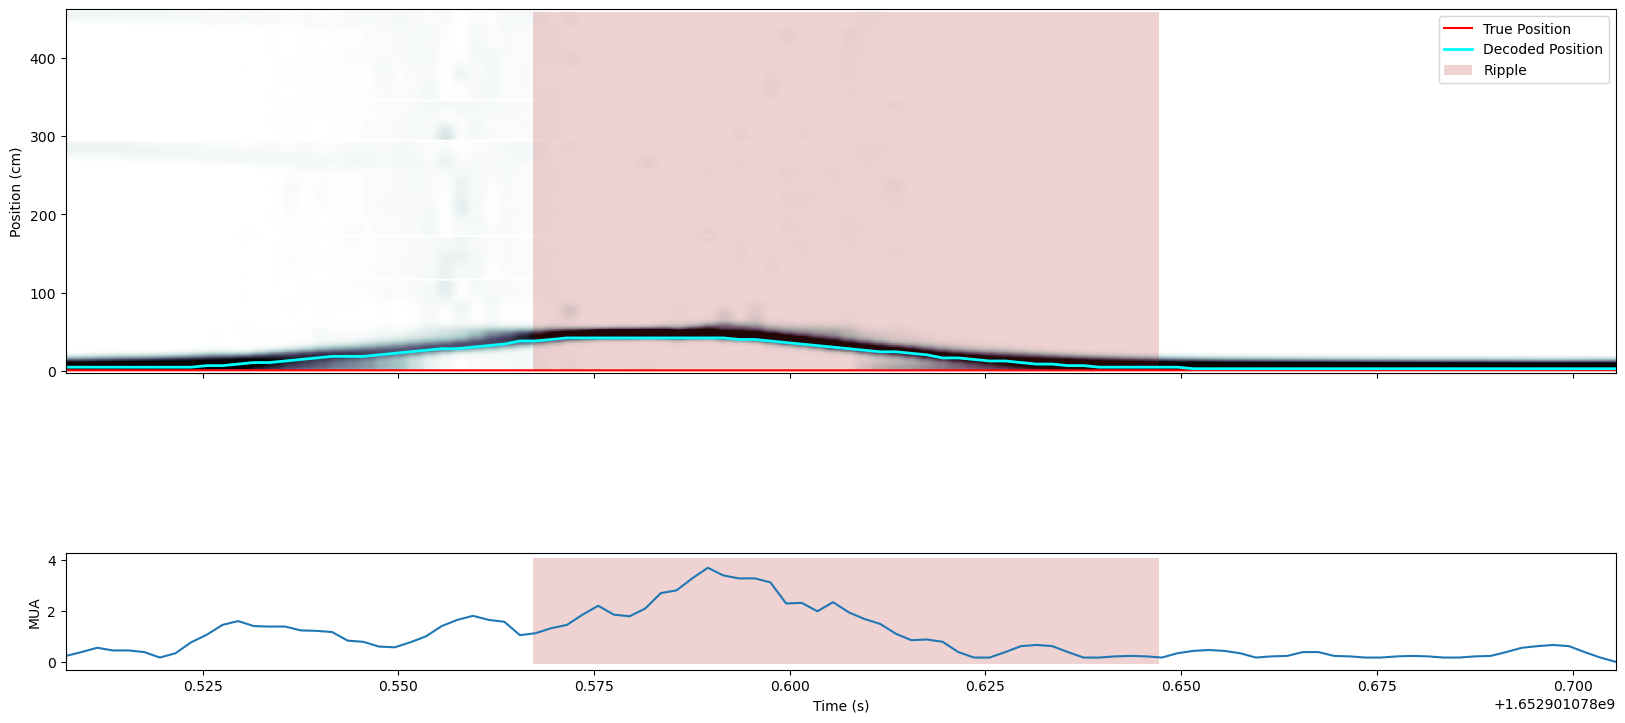

In [ ]:
plot_buffer = 30
fig, ax = plt.subplots(nrows=2, sharex=True, height_ratios=[5, 1], figsize=(20, 10))

t_plot = results.time[ind_st - plot_buffer : ind_end + plot_buffer].values
ax[0].imshow(
    posterior[ind_st - plot_buffer : ind_end + plot_buffer].T,
    clim=[0, 0.1],
    cmap="bone_r",
    aspect=1 / 10000,
    extent=[t_plot[0], t_plot[-1], np.nanmax(linear_pos), 0],
)
ax[0].plot(
    t_plot,
    linear_pos[ind_st - plot_buffer : ind_end + plot_buffer],
    "r",
    label="True Position",
)
ax[0].plot(
    t_plot,
    decode_pos[ind_st - plot_buffer : ind_end + plot_buffer],
    "cyan",
    lw=2,
    label="Decoded Position",
)
# plt.vlines(ripple_df.start_time[i],0,np.nanmax(linear_pos),color="red")
ax[0].fill_between(
    [ripple_df.start_time[i], ripple_df.end_time[i]],
    0,
    np.nanmax(linear_pos),
    facecolor="firebrick",
    alpha=0.2,
    label="Ripple",
)
ax[1].fill_between(
    [ripple_df.start_time[i], ripple_df.end_time[i]],
    -0.1,
    np.max(mua[ind_st:ind_end]) * 1.1,
    facecolor="firebrick",
    alpha=0.2,
)
ax[0].set_ylim(-3, np.nanmax(linear_pos) + 3)

ax[1].plot(t_plot, mua[ind_st - plot_buffer : ind_end + plot_buffer])

ax[0].legend()
ax[-1].set_xlabel("Time (s)")
ax[0].set_ylabel("Position (cm)")
ax[1].set_ylabel("MUA")